In [1]:
import tensorflow as tf
import tensorflow_probability as tfp

import tensorflow.keras.layers as tkl

import gym
import numpy as np
import time
from IPython import display

import matplotlib.pyplot as plt

%matplotlib inline

In [15]:
env = gym.make("LunarLander-v2")
env.reset()

n_act = env.action_space.n
n_obs = env.observation_space.shape[0]

In [201]:
class PredNet(tf.keras.Model):
    "Linear Layers, no tricks"
    def __init__(self, z):
        super(PredNet, self).__init__()
        self.latent_dim = z
        
        self.decoder = tf.keras.Sequential([
            tkl.InputLayer((z,)),
            tkl.Dense(32, activation='relu'),
            tkl.Dense(n_obs),
        ])
        
        self.encoder = tf.keras.Sequential([
            tkl.InputLayer((n_obs,)),
            tkl.Dense(32, activation='relu'),
            tkl.Reshape(target_shape=(32,1)),
#             tkl.Dense(self.latent_dim, activation=tf.nn.tanh),
            tkl.GRU(self.latent_dim, activation=tf.nn.sigmoid)
        ])        
        
    def decode(self, x):
        return self.decoder(x)
    
    def encode(self, x):
        return self.encoder(x)
    
    def full_pass(self, x, y):
        pred = self.decode(y)
        err = x - pred
        z = self.encode(err)
        return pred, z
        

In [202]:
optimizer = tf.keras.optimizers.Adam()

def compute_loss(model, x, y):
    pred, y = model.full_pass(x, y)
    pred = model.decode(y)
    err = x - pred
    
    return tf.reduce_mean(err**2)

def apply_gradients(model, x, y, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x, y)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
def generate_images(model, test_input):
    preds_ = model.decode(test_input)
    predictions = tf.reshape(preds_, (16, 28, 28))
    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4,4, i+1)
        plt.imshow(predictions[i,:,:], cmap='gray')
        plt.axis('off')
    plt.show()    

In [203]:
act = env.action_space.sample()
obs, rew, done, _ = env.step(act)

In [204]:
z = 32

model = PredNet(z)

num_examples = 16
rand_vec = tf.random.normal(shape=[num_examples, z])
y0 = tf.random.normal([1,z])

In [200]:
env.reset()
preds = []
obs_ = []
losses = []
for epoch in range(1000):
    if np.random.rand() > 0.8:
        act = env.action_space.sample()
    
    obs, rew, done, _ = env.step(act)
    
    x = tf.convert_to_tensor(obs, tf.float32)
    apply_gradients(model, x, y0, optimizer)   
    
    pred, y0 = model.full_pass(x, y0)
    preds.append(pred.numpy())
    obs_.append(obs)
    loss = tf.keras.metrics.Mean()
    loss(compute_loss(model, obs, y0))
    loss_ = loss.result()
    losses.append(loss_)

    if done:
        env.reset()


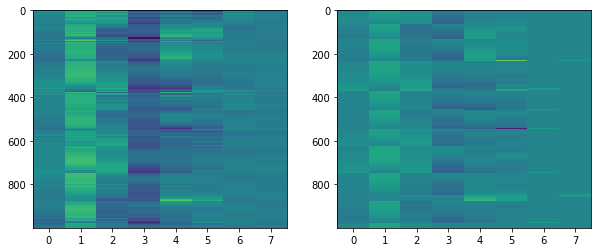

In [205]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(np.vstack(preds), aspect="auto")
plt.subplot(1,2,2)
plt.imshow(obs_, aspect="auto")

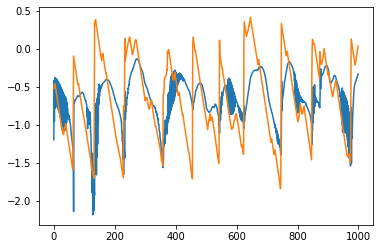

In [206]:
ind = 3
plt.plot(np.vstack(preds)[:,ind])
plt.plot(np.vstack(obs_)[:,ind])

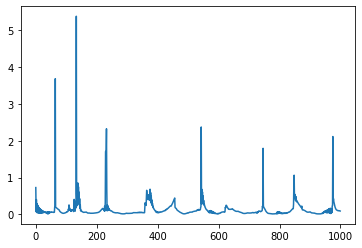

In [207]:
plt.plot(losses)

In [208]:
env.reset()
preds = []
obs_ = []
losses = []
for epoch in range(200):
    if np.random.rand() > 0.8:
        act = env.action_space.sample()
    
    obs, rew, done, _ = env.step(act)
    
    x = tf.convert_to_tensor(obs, tf.float32)
    
    pred, y0 = model.full_pass(x, y0)
    preds.append(pred.numpy())
    obs_.append(obs)
    
    loss = tf.keras.metrics.Mean()
    loss(compute_loss(model, x, y0))
    loss_ = loss.result()
    losses.append(loss_)

    if done:
        env.reset()


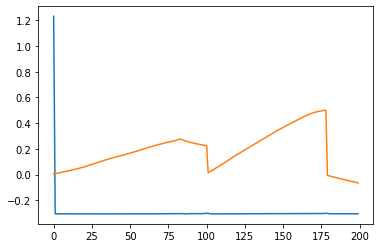

In [210]:
ind = 0
plt.plot(np.vstack(preds)[:,ind])
plt.plot(np.vstack(obs_)[:,ind])

In [219]:
R = model.weights[6].numpy()
R.shape

(1, 96)

In [220]:
np.sqrt(96)

9.797958971132712